In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, glob
from torch import load
from matplotlib.colors import LogNorm
from wmpgnn.configs.config_loader import ConfigLoader
#from wmpgnn.model.model_loader import ModelLoader

def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)


# Plot model performance

In [2]:
# Define the config files to compare
configs_to_compare = {
    "mlp_hom50": "mp_gnn_run3.yaml",
    #"mlp_hom100": "mp_gnn_run3_90k.yaml",
    #"mlp_het": "heteromp_gnn_run3.yaml",
}

# Load the config files
config_loader,datasets = {},{}
models = {}
for label, yml in configs_to_compare.items():
    config_loader[label] = ConfigLoader(f"config_files/{yml}", environment_prefix="DL")
    flatten_config = flatten_dict(config_loader[label].config)
    model_file = config_loader[label].get("training.model_file")
    csv_file = model_file.format(**flatten_config).replace(".pt",".csv")
    datasets[label] = pd.read_csv(csv_file)
    #models[label] = ModelLoader(config_loader).get_model()

In [9]:
from torch_geometric.data import HeteroData
from torch_geometric.loader import DataLoader
from particle import PDGID,Particle
def find_row_indices(t1, t2):
    # Expand t1 and t2 to compare every row in t1 with every row in t2
    t1_expanded = t1.unsqueeze(1)  # Shape (n1, 1, cols)
    t2_expanded = t2.unsqueeze(0)  # Shape (1, n2, cols)

    # Check for equality along the last dimension
    matches = (t1_expanded == t2_expanded).all(dim=2)  # Shape (n1, n2)

    # Convert matches to an appropriate type for argmax
    matches_int = matches.int()  # Convert to int

    # Find the indices in t2 for each row in t1
    indices = torch.argmax(matches_int, dim=1)


    # Verify matches exist (if no match, indices would be arbitrary)
    valid = matches.any(dim=1)
    indices[~valid] = -1  # Set unmatched rows to -1
    indice = torch.tensor([1, 0, 2])

    # Number of classes (largest value in the tensor + 1)
    num_classes = t2.shape[0]

    # One-hot encoding
    one_hot_encoded = torch.nn.functional.one_hot(indices, num_classes=num_classes)

    return indices, one_hot_encoded

def ManualDataLoader(filename_input,filenames_target):
    graph = np.load(filename_input, allow_pickle=True).item()
    for k in graph.keys():
        print(k,graph[k].shape)
    if graph['nodes'].shape[0]==0:
        print(f"Empty {i} graph: {filename_input}")
        return None
    graph_target = np.load(filenames_target, allow_pickle=True).item()
    labels = np.array(graph_target["edges"])
    indices = np.unique(graph['receivers'])
    remapping = {a: i for a, i in zip(indices, list(range(0, len(indices))))}
    old_senders = graph["senders"]
    old_receivers = graph["receivers"]
    senders = np.array([remapping[x] for x in graph["senders"]])
    receivers = np.array([remapping[x] for x in graph["receivers"]])
    senders = torch.from_numpy(senders).long()
    receivers = torch.from_numpy(receivers).long()
    new_nodes = graph["nodes"][indices]
    new_edges = graph['edges']
    new_nodes = torch.from_numpy(new_nodes)
    new_edges = torch.from_numpy(new_edges)

    # last three columns are the PVs XYZ
    recoPVs = torch.unique(new_nodes[:, -3:], dim=0)
    nPVs = recoPVs.shape[0]
    true_nodes_PVs = new_nodes[:, -3:]
    if nPVs == 0:
        print(f"Number of recoPVs=0 in event {i}: {filename_input}")
        return None
    # print(torch.sum(torch.sum(nodes_PVs == true_nodes_PVs,dim=-1)==3)/nodes_PVs.shape[0])
    y, y_one_hot = find_row_indices(true_nodes_PVs, recoPVs)

    xyz = new_nodes[:, :3]
    P = new_nodes[:, 3:6]

    xyz_repeated = xyz.unsqueeze(1).repeat(1, recoPVs.shape[0], 1)
    P_repeated = P.unsqueeze(1).repeat(1, recoPVs.shape[0], 1)
    r = xyz_repeated - recoPVs
    IPs = torch.sqrt(
        torch.sum(r ** 2, dim=-1) - torch.sum(P_repeated * r, dim=-1) ** 2 / torch.sum(P_repeated ** 2, dim=-1))

    if torch.isnan(IPs).any().item():
        IPs[torch.isnan(IPs)] = torch.max(IPs[~torch.isnan(IPs)]).item()

    permutations = torch.cartesian_prod(torch.arange(true_nodes_PVs.shape[0]), torch.arange(recoPVs.shape[0]))
    data = HeteroData()
    new_nodes = new_nodes[:, :-6]
    data['tracks'].x = new_nodes

    data['pvs'].x = recoPVs
    data['globals'].x = torch.hstack(
        [torch.from_numpy(graph["globals"]), torch.tensor(nPVs, dtype=torch.float32)]).unsqueeze(0)

    data['ids'] = torch.from_numpy(graph["ids"]).float()
    data['part_ids'] = torch.from_numpy(graph["part_ids"]).float()
    data['part_mass'] = torch.from_numpy(np.asarray([Particle.from_pdgid(id).mass for id in data["part_ids"]])).float()
    data['tracks', 'pvs'].edge_index = permutations.T
    data['tracks', 'pvs'].y = y_one_hot.flatten().unsqueeze(-1)
    data['tracks', 'pvs'].edges = IPs.flatten().unsqueeze(-1)
    n_classes=5
    data['tracks', 'tracks'].edge_index = torch.vstack([senders, receivers])
    data['tracks', 'tracks'].y = torch.from_numpy(labels[:, :n_classes])
    data['tracks', 'tracks'].edges = new_edges

    return data

In [10]:
import sys,os
sys.path.append(os.getcwd())

from wmpgnn.configs.config_loader import ConfigLoader
from wmpgnn.datasets.data_handler import DataHandler
from wmpgnn.model.model_loader import ModelLoader
from wmpgnn.trainers.gnn_trainer import GNNTrainer
from wmpgnn.trainers.hetero_gnn_trainer import HeteroGNNTrainer
import torch
from torch import nn
import glob

config_file = "heteromp_gnn_run3_onlyLongDown.yaml"
print("Loading Config")
config_loader = ConfigLoader(f"config_files/{config_file}", environment_prefix="DL")

print(f"Loading Dataset {config_loader.get('dataset.data_type')}")
data_loader = DataHandler(config_loader)
data_loader.load_data()
train_loader = data_loader.get_train_dataloader()
val_loader = data_loader.get_val_dataloader()

print(f"Initializing model {config_loader.get('model.type')}")
model_loader = ModelLoader(config_loader)
model = model_loader.get_model()

model_file = config_loader.get("training.model_file")
# format the name with info from the config file
flatten_config = flatten_dict(config_loader.config)
model_file = model_file.format(**flatten_config)
# folder for the model and other outputs
output_folder = f"outputs/{model_file.replace('.pt','')}/"
os.makedirs(output_folder, exist_ok=True)


add_bce = config_loader.get('loss.add_bce')
if config_loader.get('dataset.data_type') == "homogeneous":
    trainer = GNNTrainer(config_loader, model, train_loader, val_loader, add_bce = add_bce)
elif config_loader.get('dataset.data_type') == "heterogeneous":
    trainer = HeteroGNNTrainer(config_loader, model, train_loader, val_loader, add_bce=add_bce)
    
save_prediction = True

if save_prediction:
    trainer.model.cuda()
    #data_loader = train_loader
    #for i, data in enumerate(data_loader):
    #    data.to('cuda')
    #    outputs = trainer.model(data)
    #    label = data[('tracks', 'to', 'tracks')].y.argmax(dim=1)
    for nEv in [0]:
        filename_input = "/user/gr1/lhcb/scapelli/DFEI/lhcbdfei/data_handling/input_formatting/run3_onlyLong_magdown/training_dataset/input_{}.npy"
        filenames_target = "/user/gr1/lhcb/scapelli/DFEI/lhcbdfei/data_handling/input_formatting/run3_onlyLong_magdown/training_dataset/target_{}.npy"

        data_list = [
            ManualDataLoader(filename_input.format(nEv),filenames_target.format(nEv)),
            ManualDataLoader(filename_input.format(nEv+1),filenames_target.format(nEv+1)),
            ]
        
        data_er = DataLoader(data_list, batch_size=2, drop_last=True)
        for data in data_er:
            data = data.to('cuda')
            outputs = trainer.model(data)
            label = data[('tracks', 'to', 'tracks')].y.argmax(dim=1)
        
        break

Loading Config
Loading Dataset heterogeneous
Using 20000 events for training
Using 9076 events for validation
Using 0 events for testing
Initializing model heterognn
tensor([2.0026e-01, 6.5101e+02, 2.4969e+02, 1.0610e+03, 2.9118e+04])
Use logits  False
nodes (88, 15)
edges (7560, 4)
senders (7560,)
receivers (7560,)
globals (1,)
nodes_features (15,)
lca_chain (15,)
truth_y (30, 10)
truth_senders (30,)
truth_receivers (30,)
keys (88,)
ids (3780,)
part_ids (88,)
truth_ids (15,)
truth_part_ids (6,)
truth_part_keys (6,)
nodes (130, 15)
edges (16514, 4)
senders (16514,)
receivers (16514,)
globals (1,)
nodes_features (15,)
lca_chain (27,)
truth_y (54, 10)
truth_senders (54,)
truth_receivers (54,)
keys (130,)
ids (8257,)
part_ids (130,)
truth_ids (27,)
truth_part_ids (14,)
truth_part_keys (14,)


In [11]:
pred    = outputs[('tracks', 'to', 'tracks')].edges
label      = data[('tracks', 'to', 'tracks')].y.argmax(dim=1)
n_class =    data[('tracks', 'to', 'tracks')].y.shape[1]

correct_class = {i : 0 for i in range(n_class)}
pred_argmax = torch.argmax(pred, dim=1)
acc_err = torch.zeros(n_class)

pred_class = {i : (pred_argmax == i).sum() for i in range(n_class)}
true_class = {i : (label == i).sum() for i in range(n_class)}

if len(pred) != len(label):
    print("something goes wrong in acc_n_class")
    print(len(pred), len(label))
else:
    for i in range(n_class):
        correct_class[i] = torch.sum(pred_argmax[label == i] == label[label == i])
        #acc_err[i] = compute_efficiency_error(correct_class[i], true_class[i])

correct_preds = torch.Tensor([correct_class[i] for i in range(n_class)])

In [12]:
data

HeteroDataBatch(
  ids=[12037],
  part_ids=[218],
  part_mass=[218],
  tracks={
    x=[218, 16],
    batch=[218],
    ptr=[3],
  },
  pvs={
    x=[14, 16],
    batch=[14],
    ptr=[3],
  },
  globals={
    x=[2, 16],
    batch=[2],
    ptr=[3],
  },
  (tracks, to, pvs)={
    edge_index=[2, 1610],
    y=[1610, 1],
    edges=[1610, 16],
  },
  (tracks, to, tracks)={
    edge_index=[2, 24074],
    y=[24074, 5],
    edges=[24074, 16],
  }
)

In [13]:
data[('tracks', 'to', 'tracks')].y

tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]], device='cuda:0')

In [33]:
LCA = 1
Ms = []
m1s,m2s = [],[]
id1s,id2s = [],[]
where_d = data[('tracks', 'to', 'tracks')].y[:,LCA]== 1
where_o = torch.argmax(outputs[('tracks', 'to', 'tracks')].edges, dim=1)==LCA

print(f"Found {where_d.sum()} tracks with D and {where_o.sum()} tracks with O: {(where_d&where_o).sum()} tracks with both D and O ({(where_d&where_o).sum()/where_d.sum():.2f})")
maps = {}

for i in data[('tracks', 'to', 'tracks')].edge_index[:,where_d&where_o].T:
    n1,n2 = i.cpu().numpy()
    m1,m2 = data['part_mass'][n1].cpu().numpy(),data['part_mass'][n2].cpu().numpy()
    id1,id2 = data['part_ids'][n1].cpu().numpy(),data['part_ids'][n2].cpu().numpy()
    Ms.append(m1+m2)
    m1s.append(m1)
    m2s.append(m2)
    id1s.append(id1)
    id2s.append(id2)
    name1 = Particle.from_pdgid(id1).name
    name2 = Particle.from_pdgid(id2).name
    
    if m1+m2 not in maps.keys():
        
        maps[m1+m2] = [(name1,name2)]
        #print(f"{n1},{n2}: mass {m1+m2}({m1},{m2}) with particles {name1} and {name2}")
    else:
        if (name1,name2) not in maps[m1+m2]:
            maps[m1+m2].append((name1,name2))
            #print(f"{n1},{n2}: Duplicate mass {m1+m2}({m1},{m2}) with particles {name1} and {name2}")




Found 12 tracks with D and 2167 tracks with O: 2 tracks with both D and O (0.17)


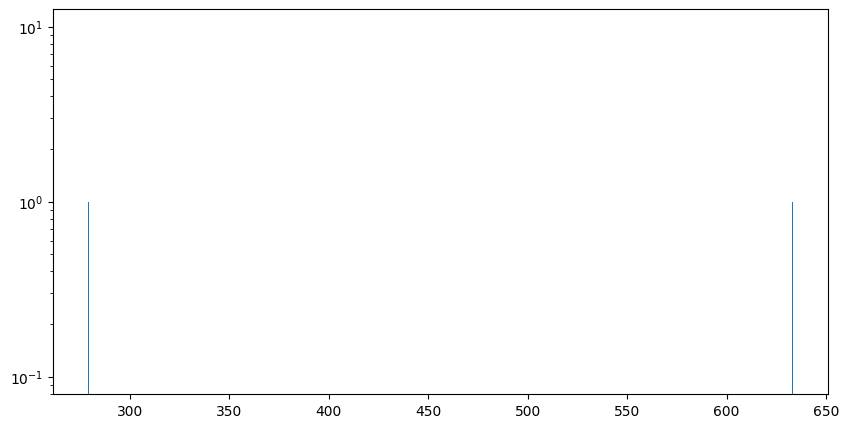

LCA1
[('pi+', 'pi+')]
[('pi+', 'K-')]


In [34]:
fig = plt.figure(figsize=(10, 5))
a = plt.hist(Ms,bins=1000)
plt.yscale('log')
plt.show()

print(f"LCA{LCA}")
for m in maps.keys():
    print(f"{maps[m]}")

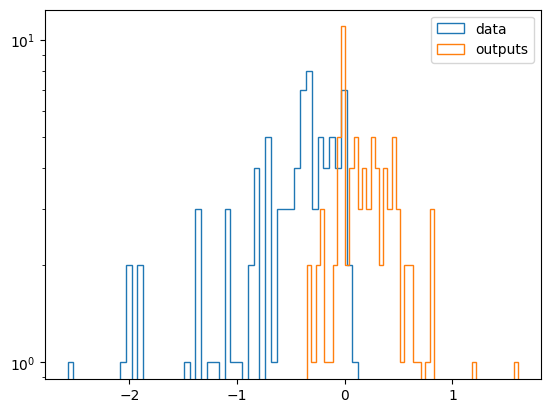

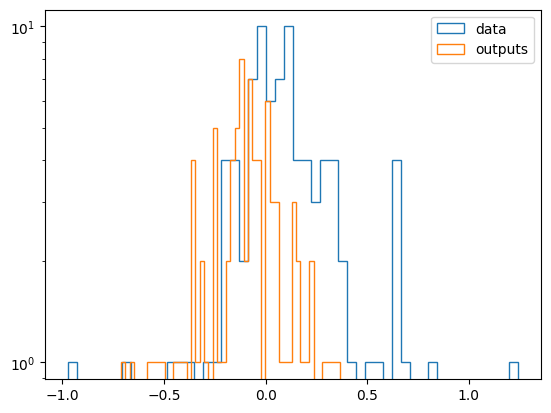

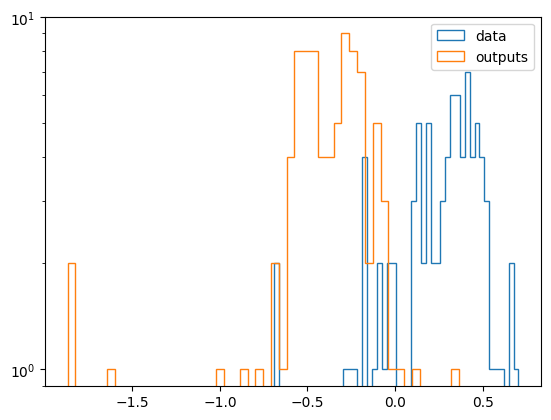

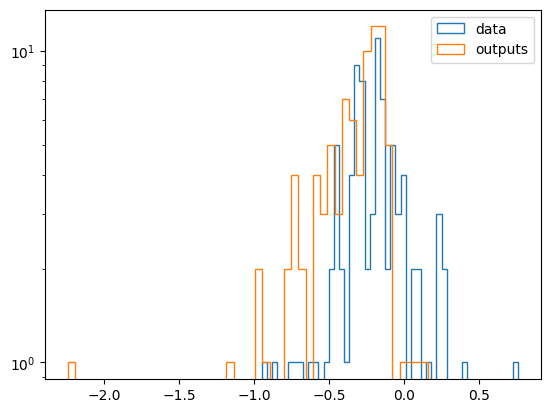

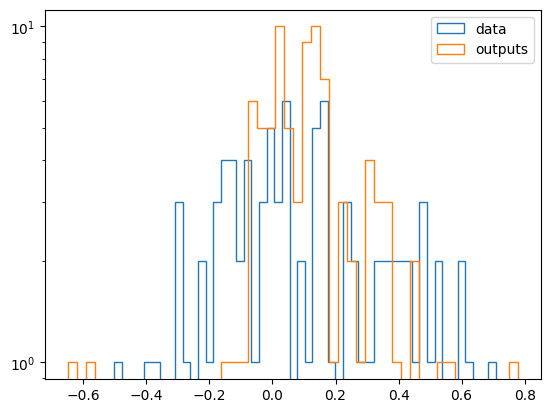

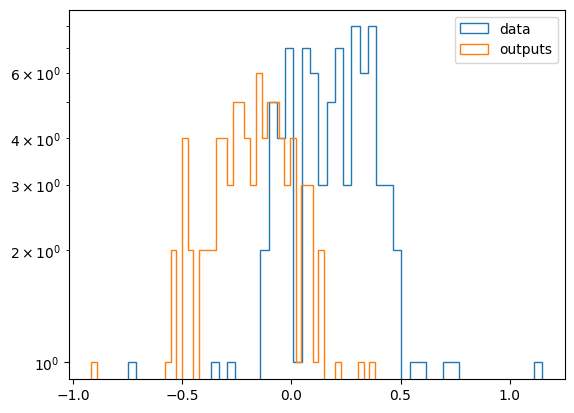

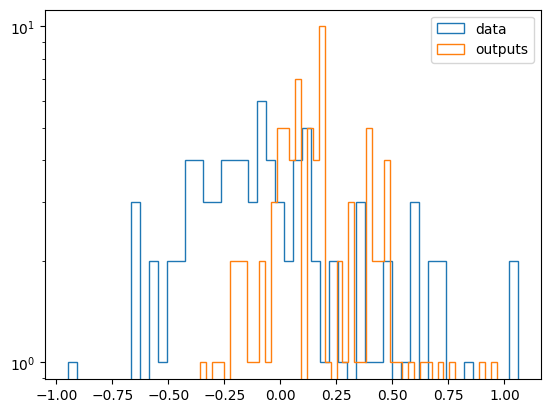

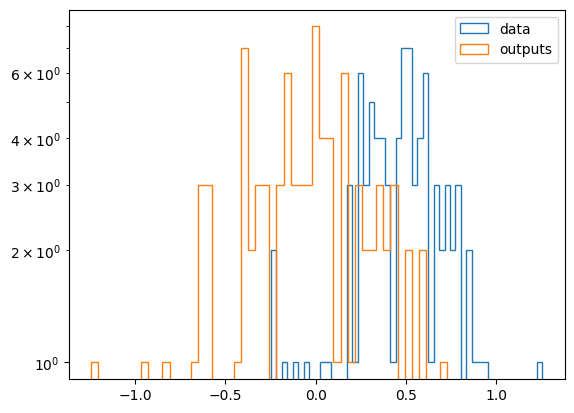

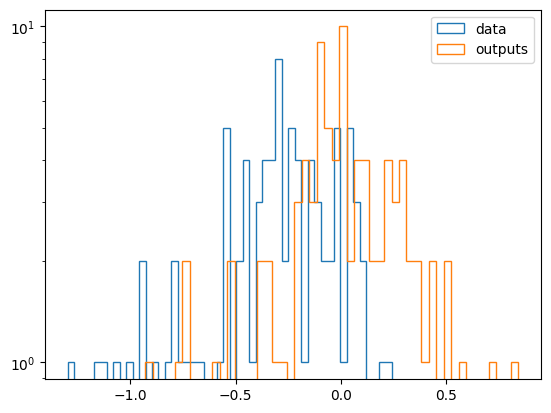

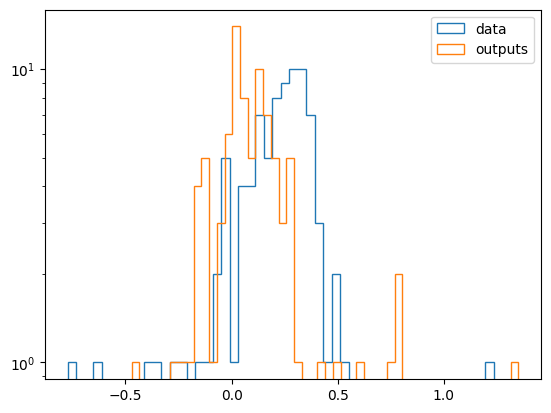

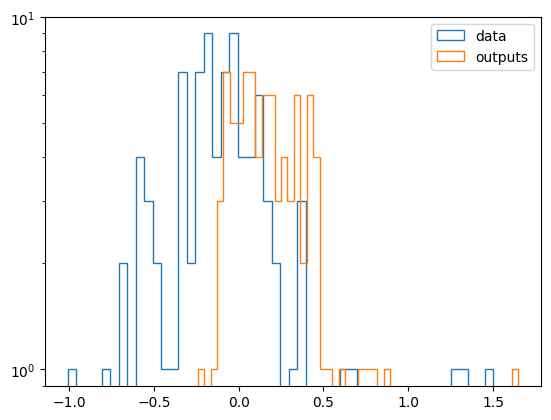

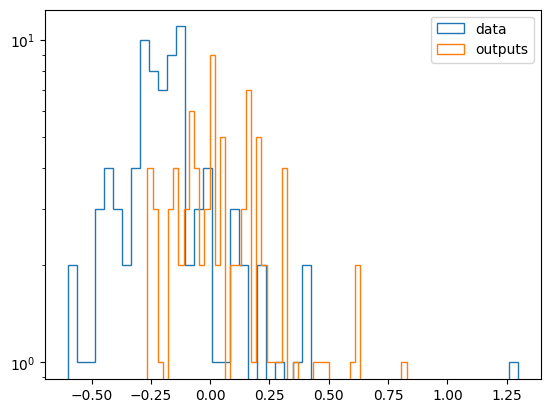

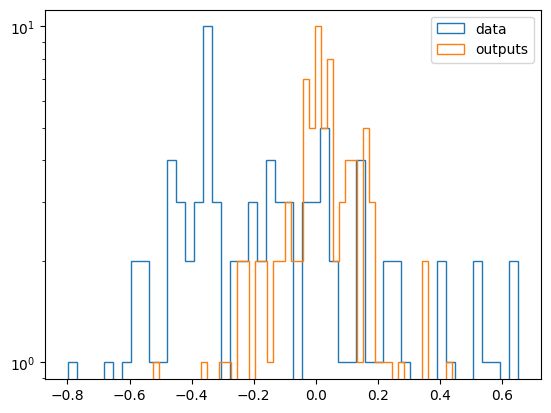

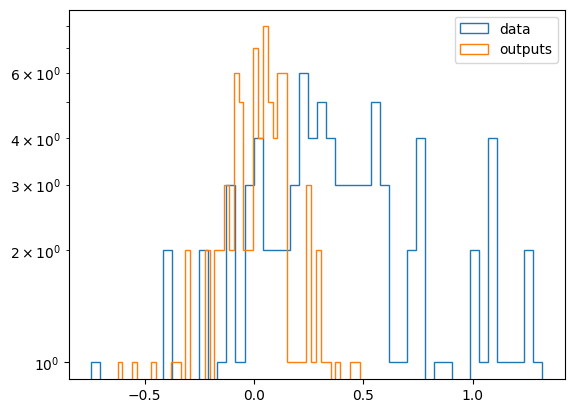

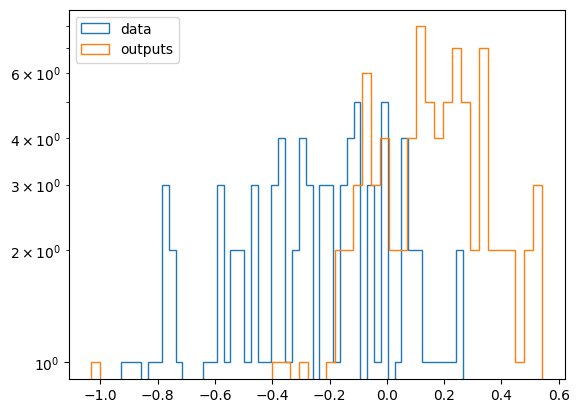

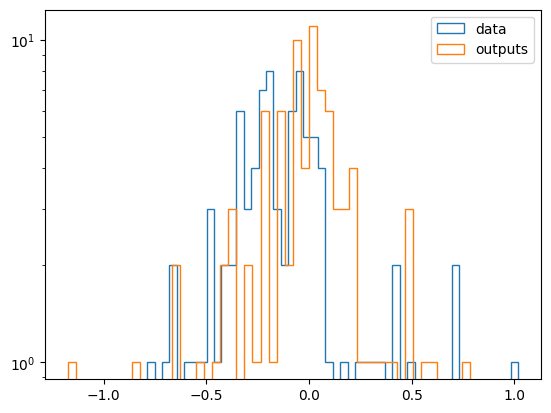

In [75]:
for i in range(data['tracks'].x.shape[1]):
    plt.hist(data['tracks'].x[data['tracks'].batch==0,i].cpu().detach().numpy(),bins=50,histtype='step',label='data')
    plt.hist(outputs['tracks'].x[data['tracks'].batch==0,i].cpu().detach().numpy(),bins=50,histtype='step',label='outputs')
    plt.yscale('log')
    plt.legend()
    plt.show()

# plot from folders

In [ ]:
# sort output stored by date
# get list of folders:
folders = glob.glob('/user/gr1/lhcb/scapelli/DFEI/weighted_MP_gnn/outputs/Final*/')
timestamps = {}
for folder in folders:
    name = folder.split('/')[-2]
    try:
        # open text file
        with open(os.path.join(folder, f'{name}.txt'), 'r') as f:
            # get lines
            lines = f.readlines()
            for line in lines:
                # if line starts with 'date', print it
                if line.startswith('Date'):
                    date = line.split(': ')[1].strip()
                    timestamps[name] = date

    except FileNotFoundError:
        pass

# 
sorted_timestamps = pd.DataFrame(timestamps.items(), columns=['Folder', 'Date']).sort_values(by='Date', ascending=False).sort_values(by='Date',ascending=False)
for i, row in sorted_timestamps.iterrows():
    print(f"{row['Folder']}: {row['Date']}")

In [23]:
# Define the output folders to compare
configs_to_compare = {
    #"full_sim" : "Final_heterogeneous_8block_10_epochs_message_passing_BCE",
    #"onlyLong" : "Final_heterogeneous_8block_10_epochs_message_passing_BCE_onlyLong15k",
    #"onlyLong+3e-3LR": "Final_heterogeneous_8block_10_epochs_message_passing_BCE_onlyLong15k_x3LR",
    #"onlyLong+2e-3LR_80k": "Final_heterogeneous_8block_10_0.002LR_epochs_message_passing_BCE_onlyLong80k",
    
    #"+2e-3LR_80k_10block_40epochs": "Final_heterogeneous_10block_40_0.002LR_epochs_message_passing_BCE_onlyLong80k",
    #"64b-up-down": "Final_heterogeneous_10block_10_0.002LR_epochs_64batch_message_passing_BCE_onlyLong80k",
    #"8-4LCA": "Final_heterogeneous_8block_20_epochs_0.002LR_32batch_message_passing_BCE_onlyLong",
    #"8-4LCA-up": "Final_heterogeneous_8block_20_epochs_0.002LR_32batch_message_passing_BCE_4LCA_onlyLongUp",
    #"8-5LCA-up": "Final_heterogeneous_8block_20_epochs_0.002LR_32batch_message_passing_BCE_5LCA_onlyLongUp",
    #"10-5LCA-up": "Final_heterogeneous_10block_20_epochs_0.002LR_32batch_message_passing_BCE_5LCA_onlyLongUp",
    #"10-5LCA-down": "Final_heterogeneous_10block_20_epochs_0.002LR_32batch_message_passing_BCE_5LCA_onlyLongDown",
    '12-20-0.02-Up-hom' :"Final_homogeneous_12block_20_epochs_message_passing_BCE_OnlyUp",
    '12-30-0.03-Up' :"Final_heterogeneous_12block_30_epochs_0.003LR_16batch_message_passing_BCE_5LCA_onlyLongUp",
    '10-30-0.02-Up' :"Final_heterogeneous_10block_30_epochs_0.002LR_32batch_message_passing_BCE_5LCA_onlyLongUp",
    '10-40-0.03-Down' :"Final_heterogeneous_10block_40_epochs_0.003LR_32batch_message_passing_BCE_5LCA_onlyLongDown",
    '10-20-0.02-Down' :"Final_heterogeneous_10block_20_epochs_0.002LR_32batch_message_passing_BCE_5LCA_onlyLongDown",
}

# Load the config files
datasets = {}
models = {}
for label, folder in configs_to_compare.items():
    model_file = f"outputs/{folder}/{folder}.pt"
    csv_file = f"outputs/{folder}/{folder}.csv"
    datasets[label] = pd.read_csv(csv_file)

## loss

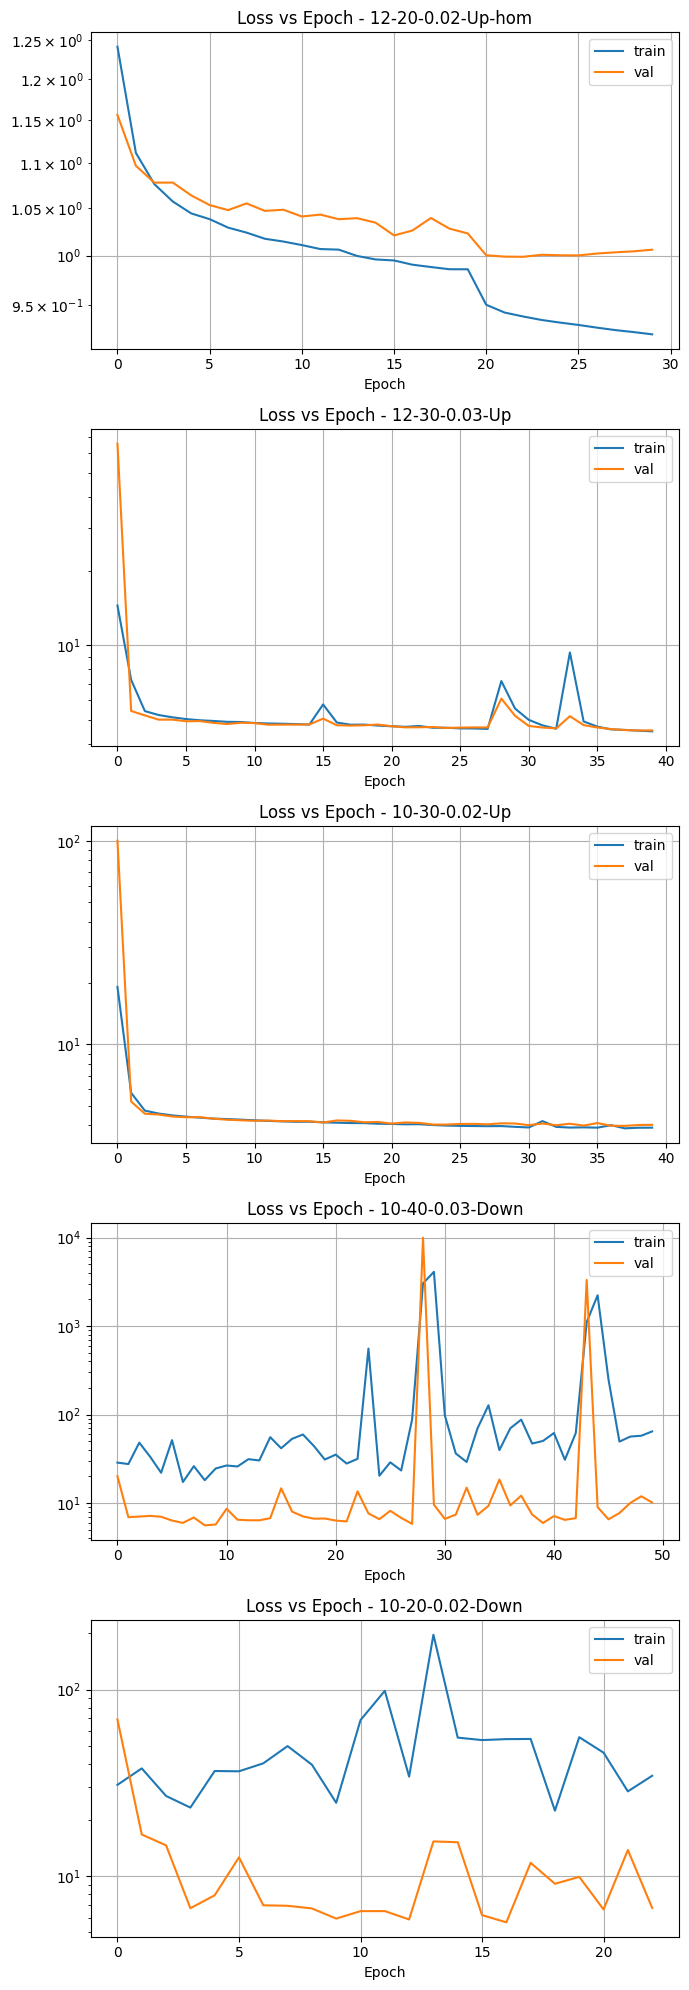

In [24]:
models = list(datasets.keys())

Nmodels = len(models)
fig, axs = plt.subplots(Nmodels, 1, figsize=(7,4*Nmodels))
if Nmodels == 1:
    axs = [axs]
for i,label in enumerate(datasets.keys()):
    axs[i].plot(datasets[label][f"train_loss"], label=f"train")
    axs[i].plot(datasets[label][f"val_loss"], label=f"val")
    axs[i].set_xlabel('Epoch')
    axs[i].grid()
    #axs[i].set_xlim(8, 11)
    #axs[i].set_ylim(1, 6)
    axs[i].set_yscale('log')
    axs[i].set_title(f"Loss vs Epoch - {label}")
    axs[i].legend()
plt.tight_layout()
plt.show()

## metrics

Error: train_acc_LCA0_err not found in dataset
Error: val_acc_LCA0_err not found in dataset
Error: train_acc_LCA1_err not found in dataset
Error: val_acc_LCA1_err not found in dataset
Error: train_acc_LCA2_err not found in dataset
Error: val_acc_LCA2_err not found in dataset
Error: train_acc_LCA3_err not found in dataset
Error: val_acc_LCA3_err not found in dataset
Error: train_acc_LCA4_err not found in dataset
Error: val_acc_LCA4_err not found in dataset
Error: train_eff_LCA0_err not found in dataset
Error: val_eff_LCA0_err not found in dataset
Error: train_eff_LCA1_err not found in dataset
Error: val_eff_LCA1_err not found in dataset
Error: train_eff_LCA2_err not found in dataset
Error: val_eff_LCA2_err not found in dataset
Error: train_eff_LCA3_err not found in dataset
Error: val_eff_LCA3_err not found in dataset
Error: train_eff_LCA4_err not found in dataset
Error: val_eff_LCA4_err not found in dataset
Error: train_rej_LCA0_err not found in dataset
Error: val_rej_LCA0_err not found

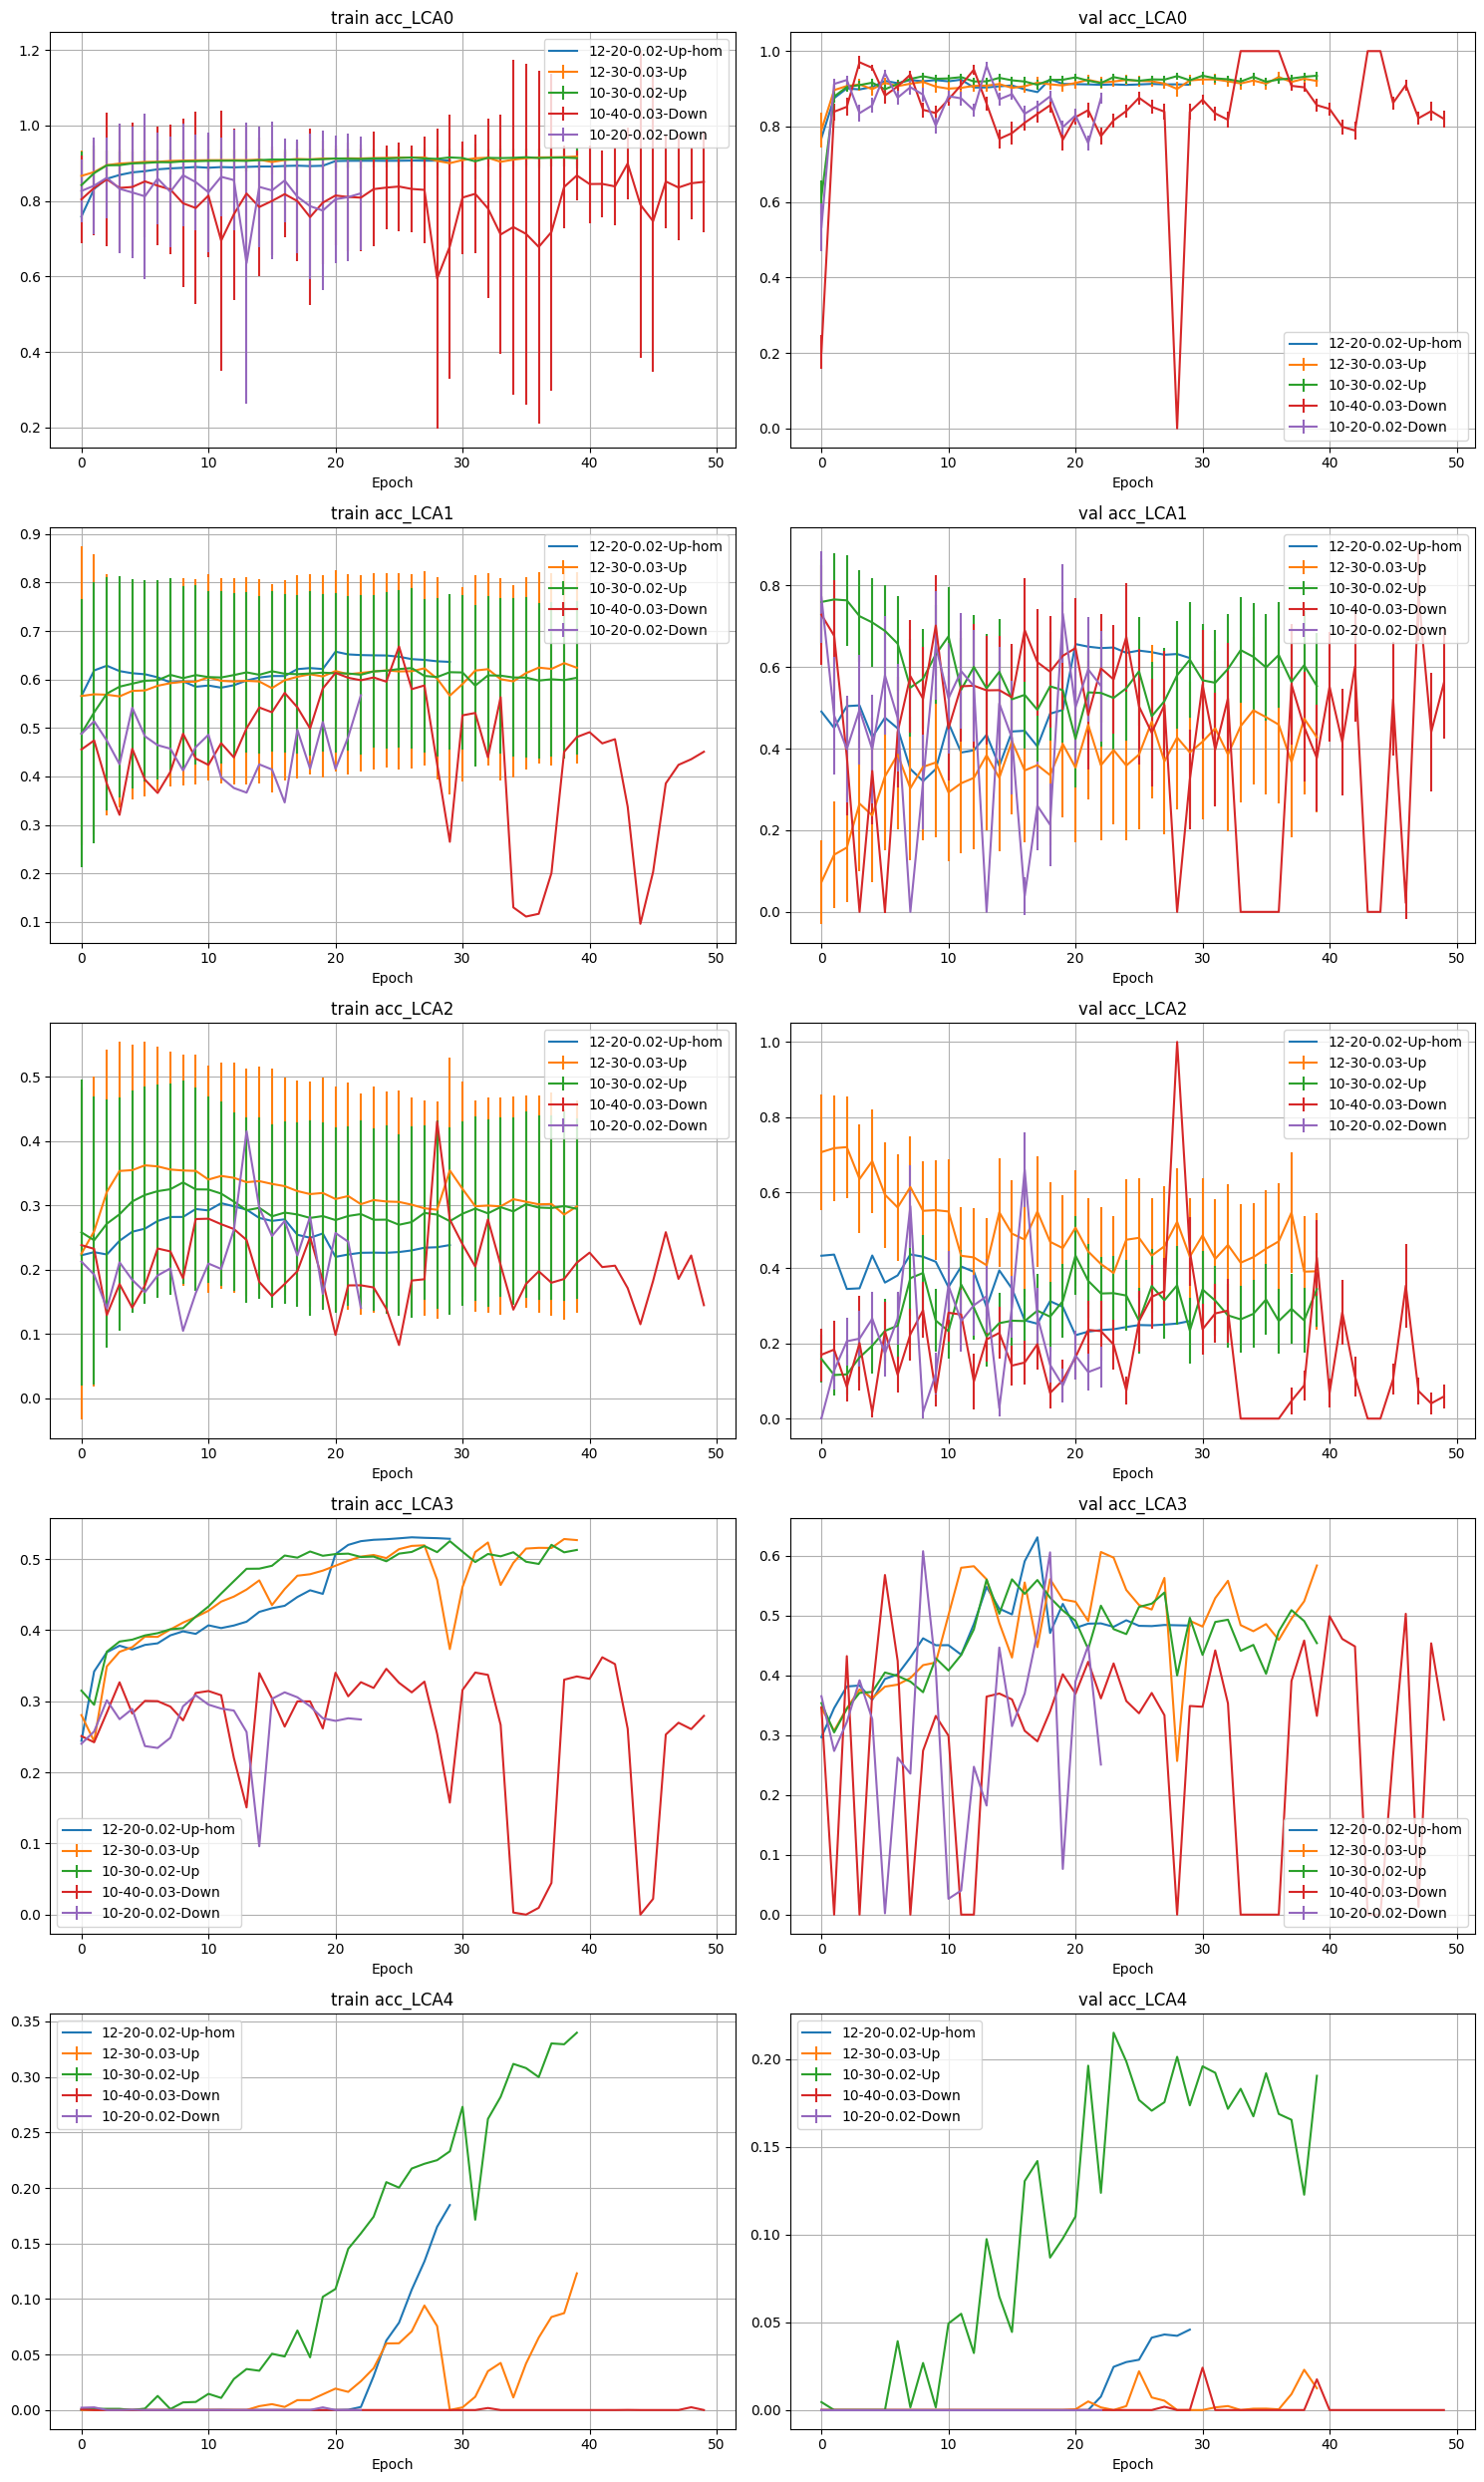

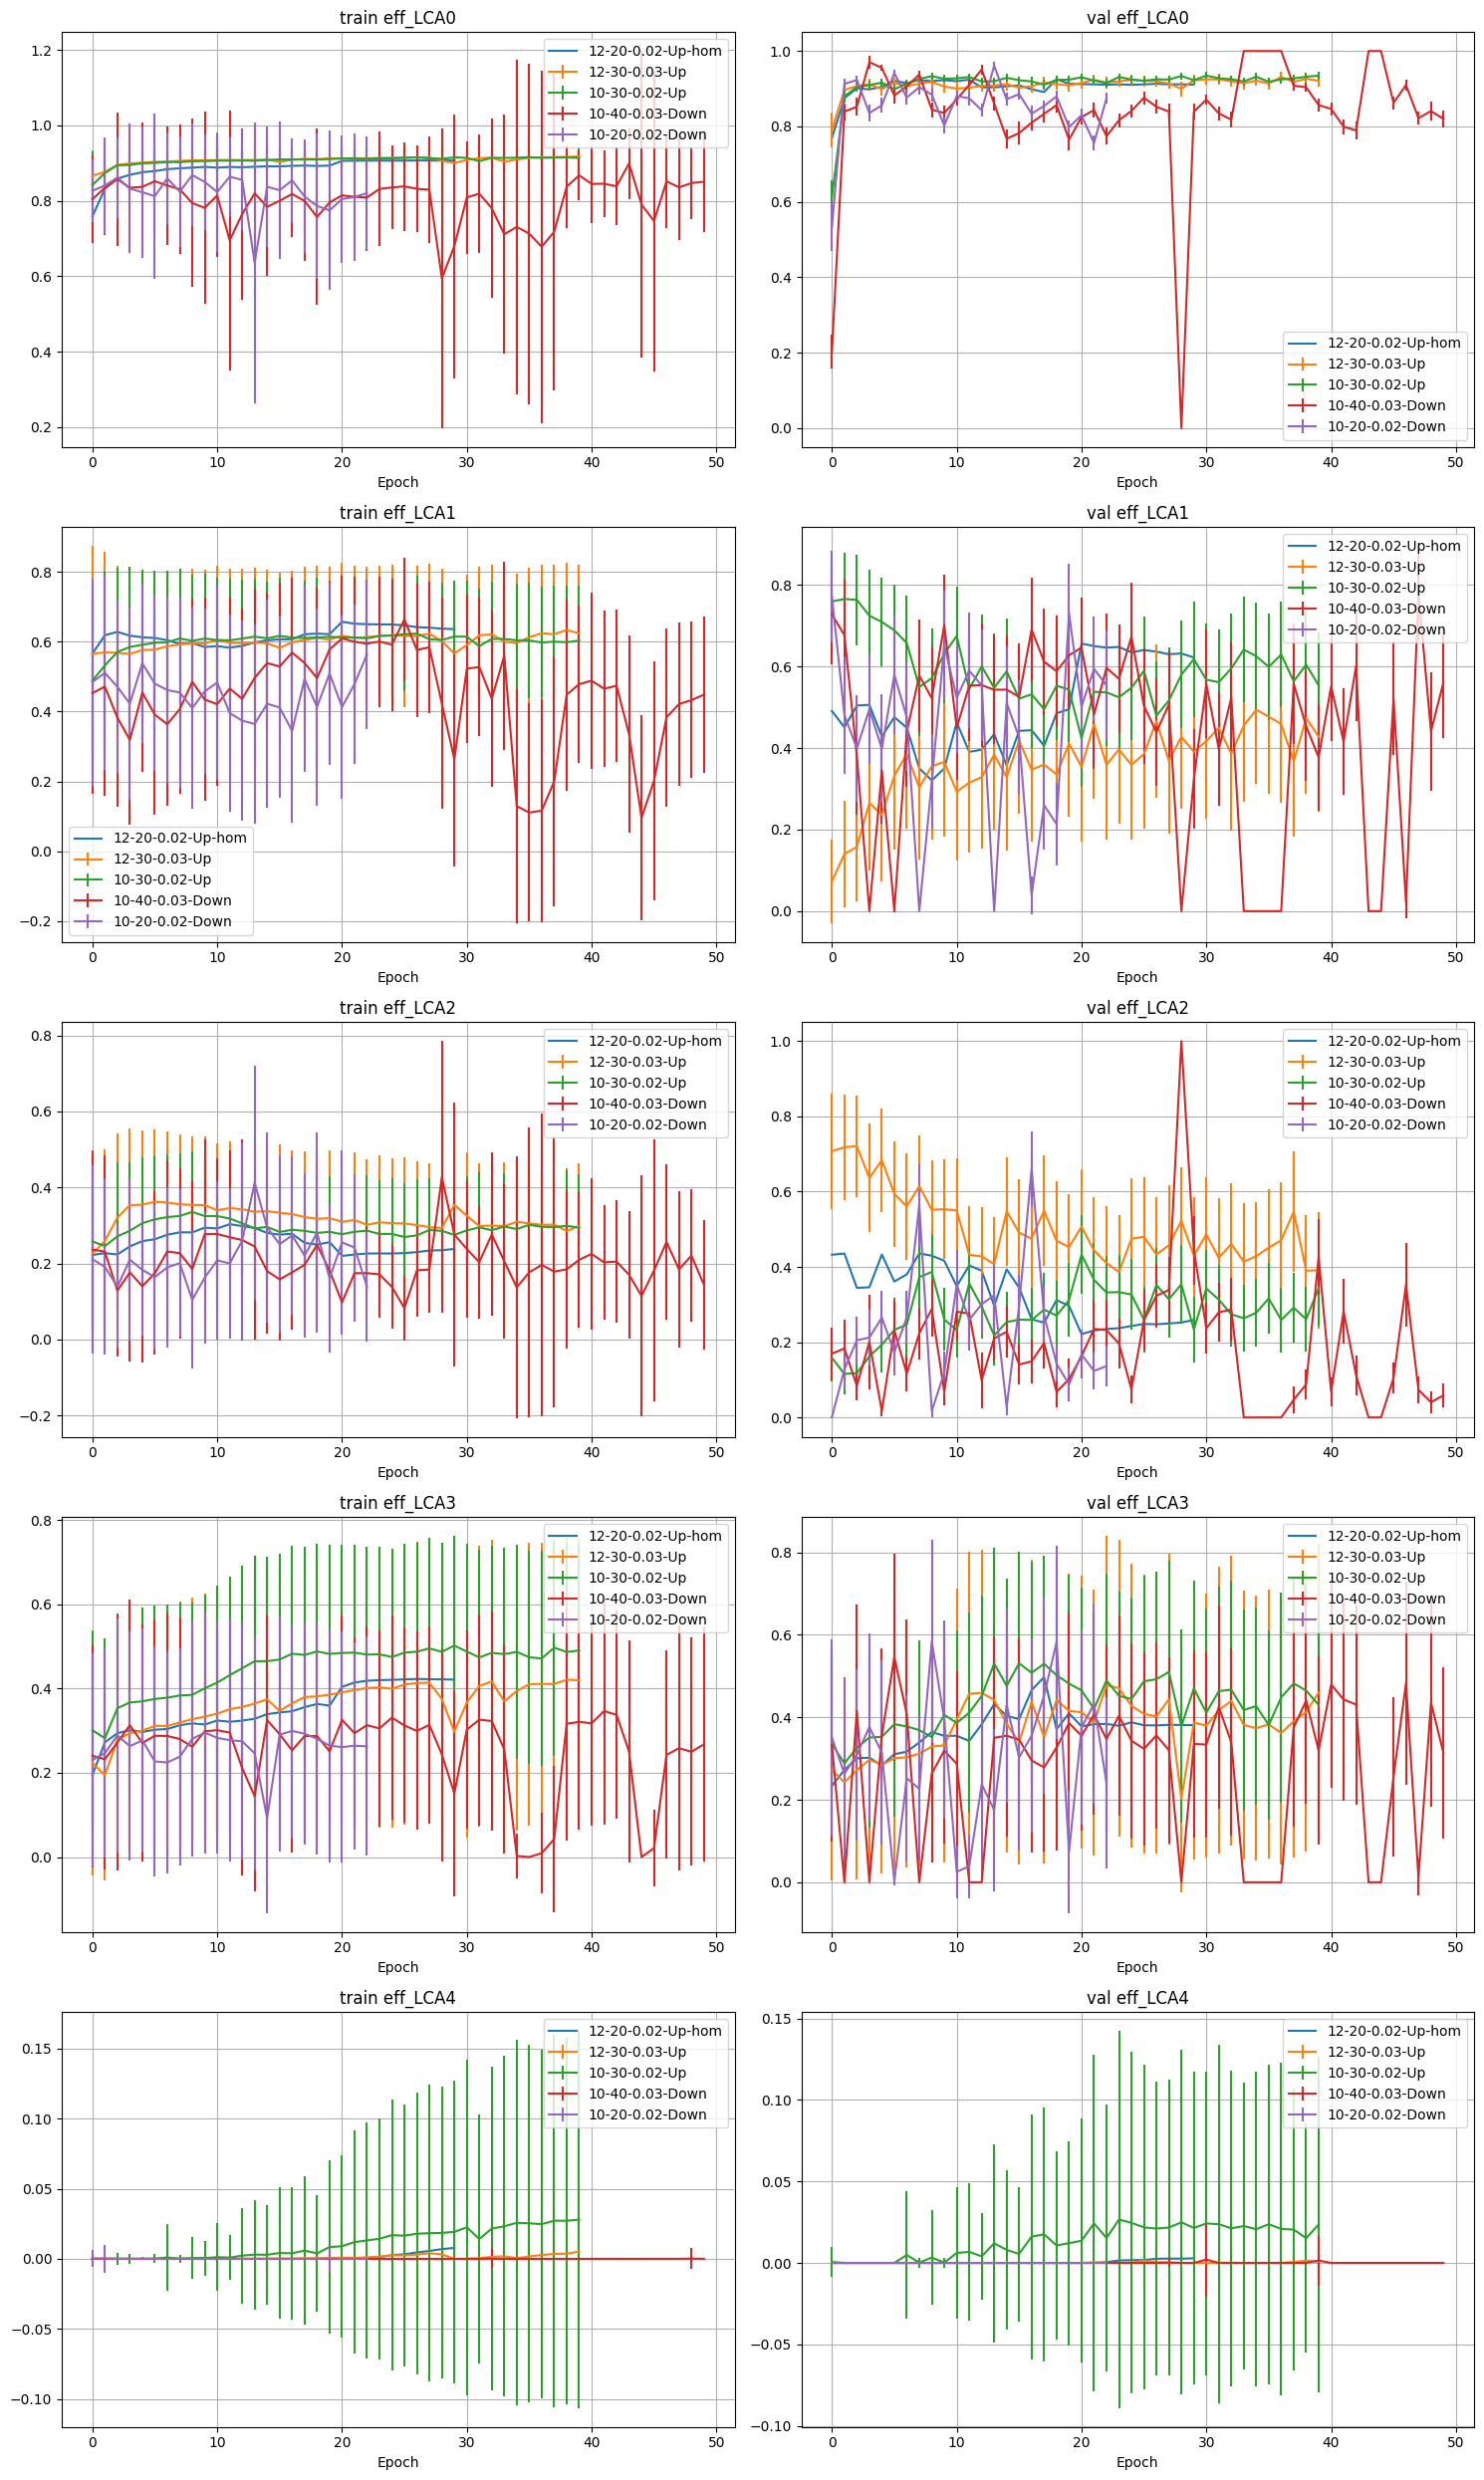

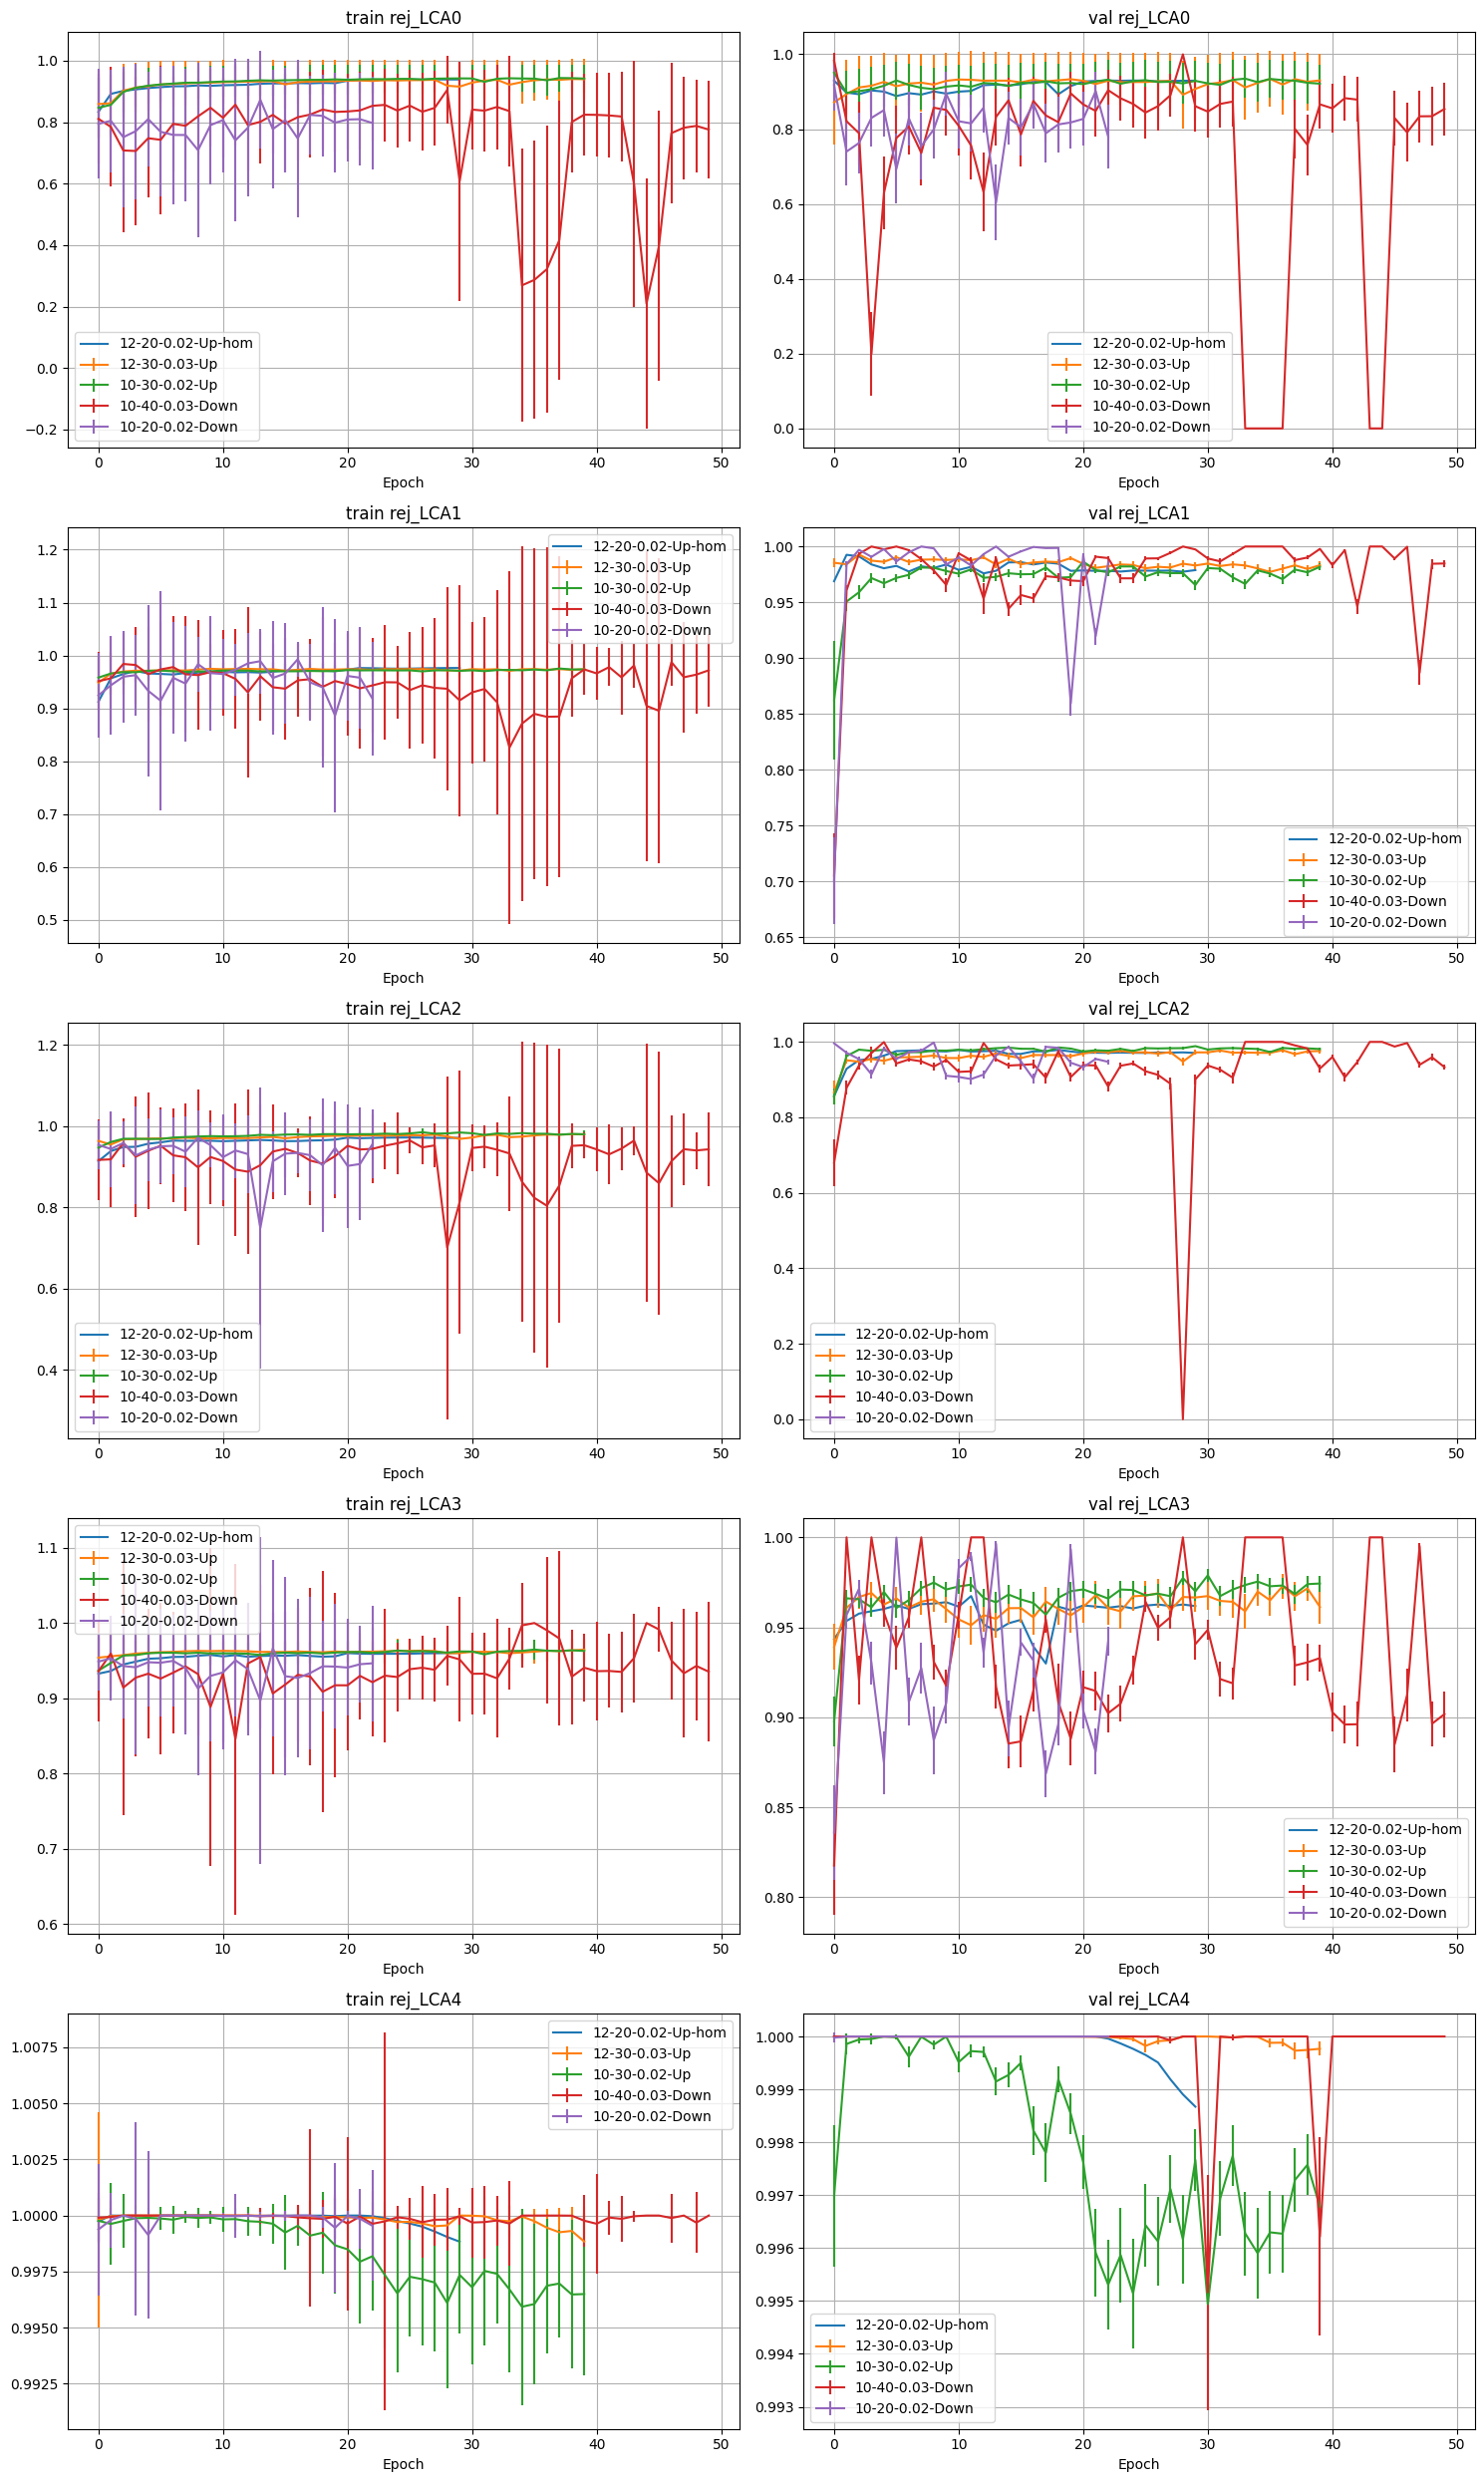

In [25]:
def SmartPlot(ax,dataset,sample,plot_errors=True,**kwargs):
    """ plot over axes depending on the inputs"""
    
    x = dataset.index
    try:
        y = dataset[sample]
    except KeyError:
        return ax
    
    if plot_errors:
        try:
            yerr = dataset[sample+"_err"]
        except:
            print(f"Error: {sample}_err not found in dataset")
            yerr = None
    
    if yerr is not None:
        ax.errorbar(x, y,yerr=yerr, **kwargs)
    else:
        ax.plot(x, y, **kwargs)
    
    return ax

def PlotMetric(datasets,metric='acc'):
    """ plot the metric for each model """
    
    features = [metric+f'_LCA{i}' for i in range(5)] #['acc_LCA0', 'acc_LCA1', 'acc_LCA2', 'acc_LCA3', 'acc_LCA4']

    Nfeatures = len(features)
    fig, axs = plt.subplots(Nfeatures, 2, figsize=(15, 5*Nfeatures))
    for i, feature in enumerate(features):
        for label in configs_to_compare.keys():
            axs[i,0] = SmartPlot(axs[i,0],datasets[label], f"train_{feature}",plot_errors=True, label=label)
            axs[i,1] = SmartPlot(axs[i,1],datasets[label], f"val_{feature}"  ,plot_errors=True, label=label)
            #axs[i,0].plot(datasets[label][f"train_{feature}"], label=label)
            #axs[i,1].plot(datasets[label][f"val_{feature}"], label=label)
            
            axs[i,0].set_title(f"train {feature}")
            axs[i,1].set_title(f"val {feature}")
            
        for ax in axs[i]:
            ax.set_xlabel('Epoch')
            ax.grid()
            #ax.set_title(feature)
            ax.legend()
    plt.tight_layout()

def PlotMetricComb(datasets,metric='acc'):
    """ plot the metric for each model """
    
    features = [metric+f'_LCA{i}' for i in range(5)] #['acc_LCA0', 'acc_LCA1', 'acc_LCA2', 'acc_LCA3', 'acc_LCA4']

    Nfeatures = len(features)
    fig, axs = plt.subplots(Nfeatures, 1, figsize=(8, 5*Nfeatures))
    for i, feature in enumerate(features):
        for label in configs_to_compare.keys():

            axs[i] = SmartPlot(axs[i],datasets[label].index, datasets[label][f"train_{feature}"],yerr=datasets[label][f"train_{feature}_err"], label=label)
            axs[i] = SmartPlot(axs[i],datasets[label].index, datasets[label][f"val_{feature}"],yerr=datasets[label][f"val_{feature}_err"], label=label)

            #axs[i].plot(datasets[label][f"train_{feature}"], label=f"train_{label}")
            #axs[i].plot(datasets[label][f"val_{feature}"], label=f"val_{label}")

        axs[i].set_xlabel('Epoch')
        axs[i].grid()
        axs[i].set_title(feature)
        axs[i].legend()
    
        
PlotMetric(datasets,metric='acc')
PlotMetric(datasets,metric='eff')
PlotMetric(datasets,metric='rej')

#PlotMetricComb(datasets,metric='acc')
#PlotMetricComb(datasets,metric='eff')
#PlotMetricComb(datasets,metric='rej')

## Heterogeneous model

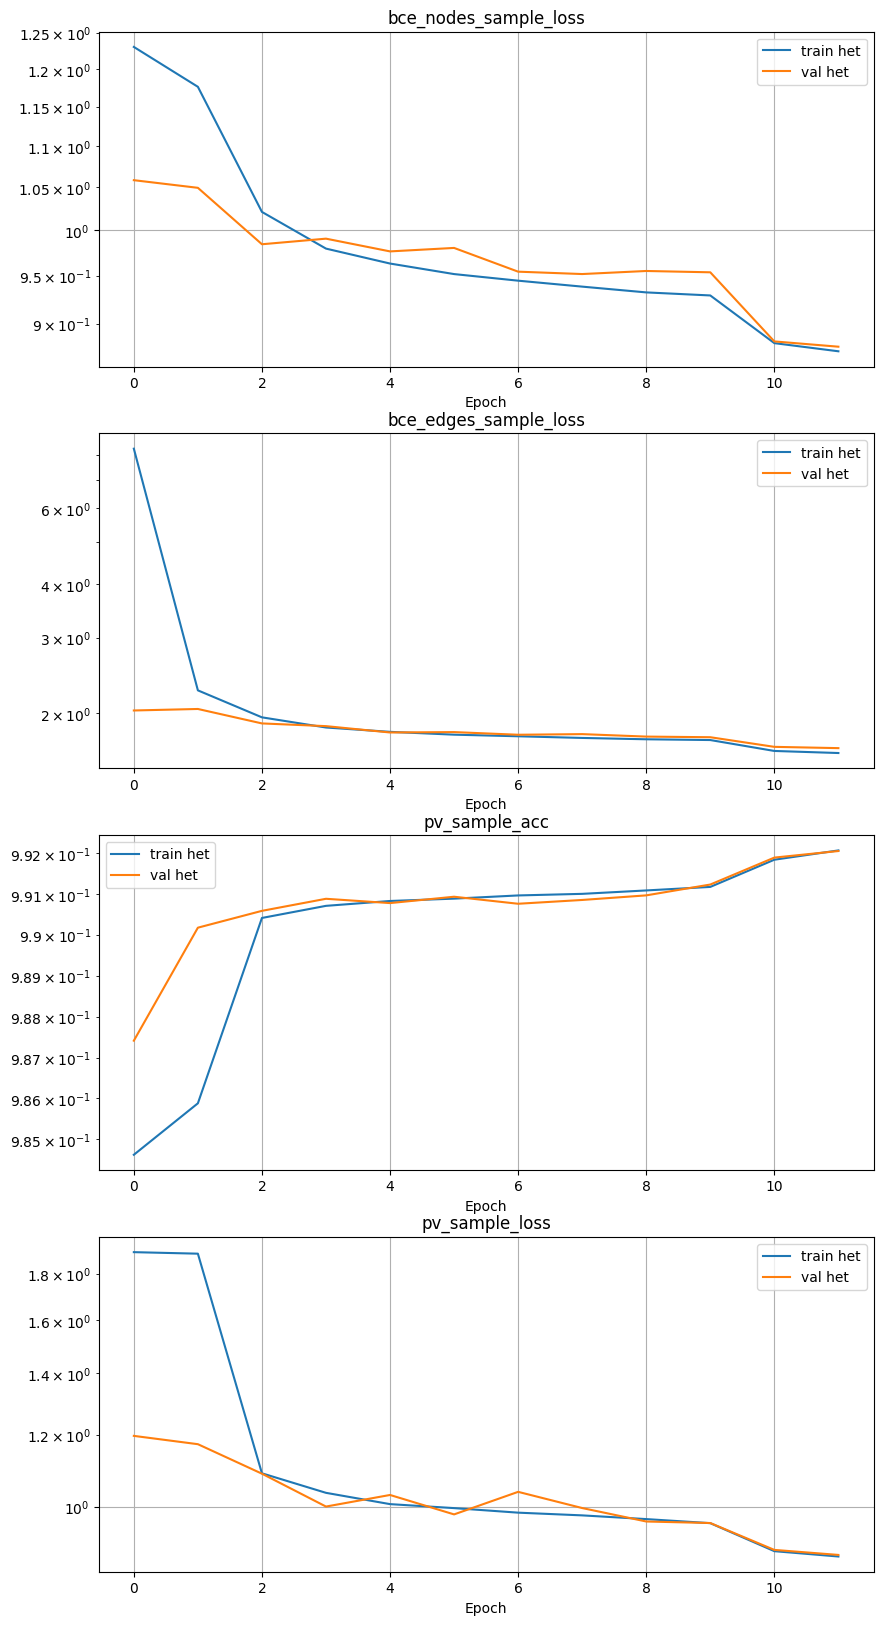

In [33]:
features = ['bce_nodes_sample_loss',
       'bce_edges_sample_loss', 'pv_sample_acc', 'pv_sample_loss']

Nfeatures = len(features)
fig, axs = plt.subplots(Nfeatures, 1, figsize=(10, 5*Nfeatures))
for i, feature in enumerate(features):
    for sample in ['train','val']:
        axs[i].plot(datasets["onlyLong+2e-3LR_80k_10block"][feature.replace("sample",sample)], label=f"{sample} het")
    axs[i].set_xlabel('Epoch')
    axs[i].grid()
    axs[i].set_yscale('log')
    axs[i].set_title(feature)
    axs[i].legend()

## Checkpoint loader

In [29]:
checkpoint['history'].keys()

dict_keys(['train_loss', 'train_acc', 'train_eff', 'train_rej', 'train_acc_err', 'train_eff_err', 'train_rej_err', 'val_loss', 'val_acc', 'val_eff', 'val_rej', 'val_acc_err', 'val_eff_err', 'val_rej_err', 'ce_train_loss', 'ce_val_loss', 'bce_nodes_train_loss', 'bce_nodes_val_loss', 'bce_edges_train_loss', 'bce_edges_val_loss', 'bce_pvs_train_loss', 'bce_pvs_val_loss', 'train_pv_acc', 'train_pv_acc_err', 'val_pv_acc', 'val_pv_acc_err', 'train_node_pv_acc', 'train_node_pv_acc_err', 'val_node_pv_acc', 'val_node_pv_acc_err'])

In [5]:
def FormatHistory(history):
    """return a dictionary with the history of the training for each metrics and class"""
    metrics = {
        'train' : {},
        'val' : {}
    }
    length = len(history['train_loss'])
    for sample in metrics.keys():
        metrics[sample]['loss'] = history[f"{sample}_loss"]
        for metric in ['acc','eff','rej']:
            metrics[sample][metric] = np.array([history[f"{sample}_{metric}"][i] for i in range(length)])
            metrics[sample][metric+'_err'] = np.array([history[f"{sample}_{metric}_err"][i] for i in range(length)])
            for metric in ['bce_nodes','bce_edges','bce_pvs']:
                try:
                    metrics[sample][metric+'_loss'] = np.array([history[f"{metric}_{sample}_loss"][i] for i in range(length)])
                except KeyError:
                    print(f"KeyError: {metric}_{sample}_loss not found in history")
            for metric in ['pv_acc','pv_acc_err','node_pv_acc','node_pv_acc_err']:
                try:
                    metrics[sample][metric] = np.array([history[f"{sample}_{metric}"][i] for i in range(length)])
                except KeyError:
                    print(f"KeyError: {sample}_{metric} not found in history")
    return metrics

# Define the config files to compare
configs_to_compare = {
    #"mlp_hom50": "mp_gnn_run3.yaml",
    #"mlp_hom100": "mp_gnn_run3_90k.yaml",
    "mlp_het": "heteromp_gnn_run3_onlyLong.yaml",
}


config_loader = ConfigLoader(f"config_files/{configs_to_compare['mlp_het']}", environment_prefix="DL")
flatten_config = flatten_dict(config_loader.config)
model_file = config_loader.get("training.model_file").format(**flatten_config)
checkpoint_folder = model_file.replace(".pt","")
checkpoint_files = glob.glob(f"outputs/{checkpoint_folder}/checkpoint*")
histories = {}
for chk_file in checkpoint_files:
    # extrack epoch from filename
    checkpoint = load(chk_file,weights_only=True)
    histories[checkpoint['epoch_warmstart']] = FormatHistory(checkpoint['history'])

add_dataset = True
csv_file = model_file.replace(".pt",".csv")
try:
    dataset = pd.read_csv(f"outputs/{checkpoint_folder}/{csv_file}")
except FileNotFoundError:
    add_dataset = False

IndexError: index 5 is out of bounds for axis 1 with size 5

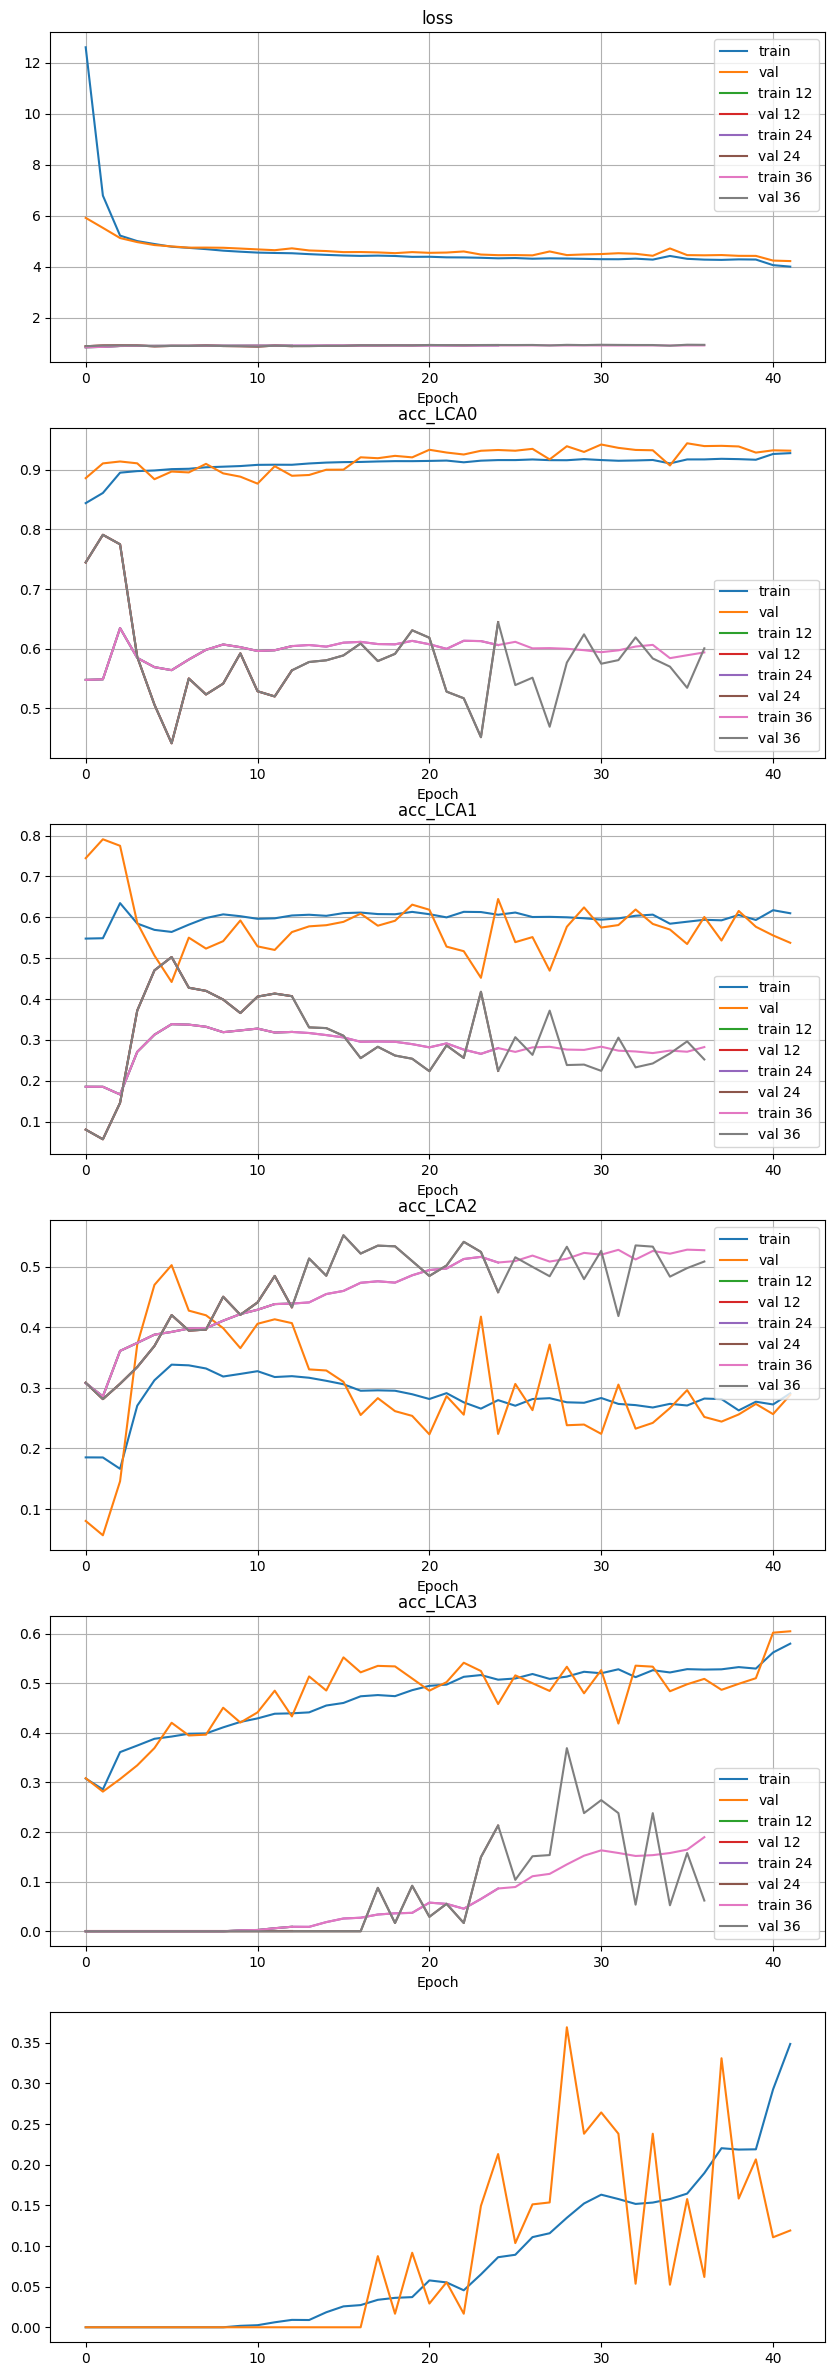

In [8]:
features = ['acc_LCA0', 'acc_LCA1', 'acc_LCA2', 'acc_LCA3', 'acc_LCA4']

Nfeatures = len(features)
fig, axs = plt.subplots(Nfeatures, 1, figsize=(10, 5*Nfeatures))
for i, feature in enumerate(features):
    
    if add_dataset:
        axs[i].plot(dataset[f"train_{feature}"], label=f"train")
        axs[i].plot(dataset[f"val_{feature}"], label=f"val")
    
    # add checkpoints
    for epoch,history in histories.items():
        length = history['train']['acc'].shape[0]
        x = np.arange(0, epoch+1)
        axs[i].plot(x,history['train']['acc'][:,i], label=f"train {epoch}")
        axs[i].plot(x,history['val']['acc'][:,i], label=f"val {epoch}")
    
    axs[i].set_xlabel('Epoch')
    axs[i].grid()
    axs[i].set_title(feature)
    axs[i].legend()
    


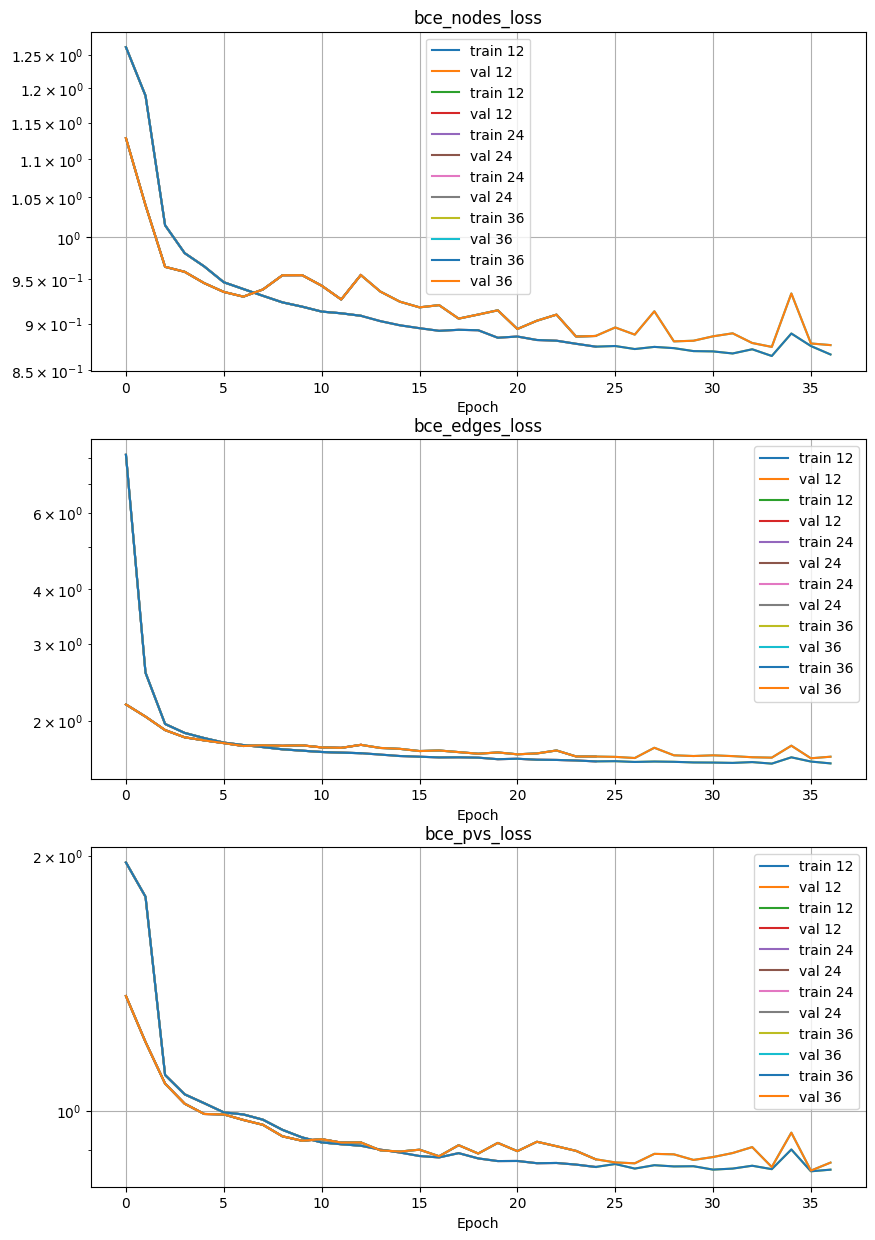

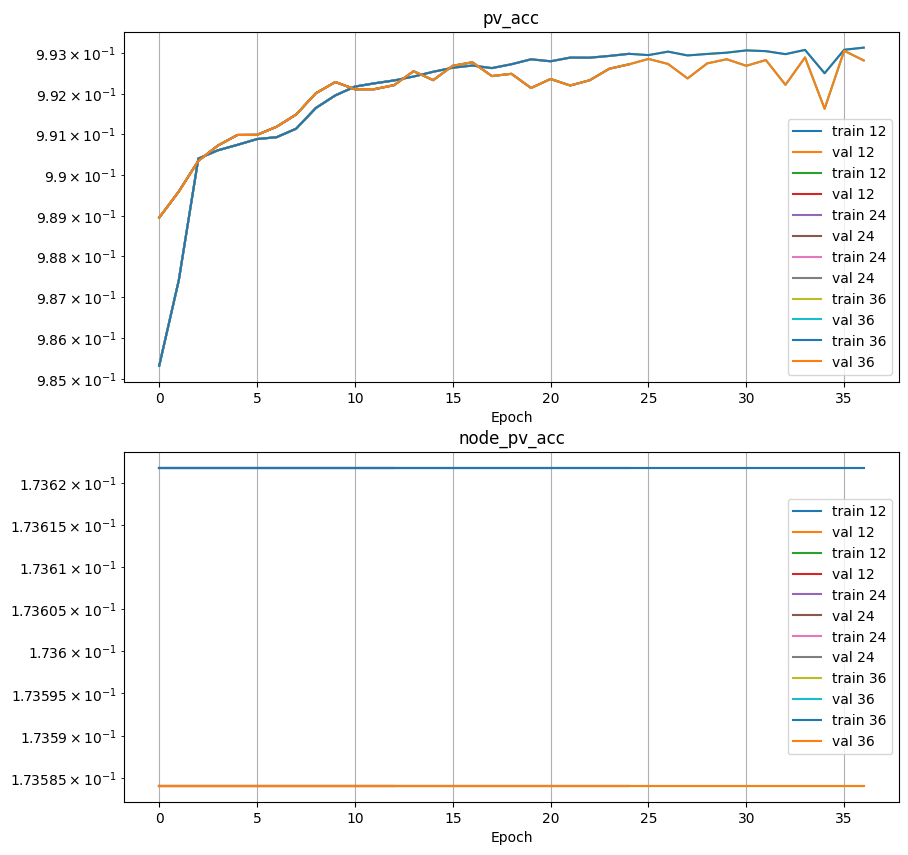

In [7]:
# for heterogeneous model only
features = ['bce_nodes_loss', 'bce_edges_loss', 'bce_pvs_loss']

Nfeatures = len(features)
fig, axs = plt.subplots(Nfeatures, 1, figsize=(10, 5*Nfeatures))
for epoch,history in histories.items():
    for i, feature in enumerate(features):
        for sample in ['train','val']:
            axs[i].plot(history['train'][feature], label=f"train {epoch}")
            axs[i].plot(history['val'][feature], label=f"val {epoch}")
            #axs[i].plot(dataset[feature.replace("sample",sample)], label=f"{sample} mlp_het")
        axs[i].set_xlabel('Epoch')
        axs[i].grid()
        axs[i].set_yscale('log')
        axs[i].set_title(feature)
        axs[i].legend()
    
features = ['pv_acc', 'node_pv_acc']

Nfeatures = len(features)
fig, axs = plt.subplots(Nfeatures, 1, figsize=(10, 5*Nfeatures))
for epoch,history in histories.items():
    x = np.arange(0, epoch+1)
    for i, feature in enumerate(features):
        for sample in ['train','val']:
            axs[i].plot(history['train'][feature], label=f"train {epoch}")
            axs[i].plot(history['val'][feature], label=f"val {epoch}")
            #axs[i].plot(dataset[feature.replace("sample",sample)], label=f"{sample} mlp_het")
        axs[i].set_xlabel('Epoch')
        axs[i].grid()
        axs[i].set_yscale('log')
        axs[i].set_title(feature)
        axs[i].legend()

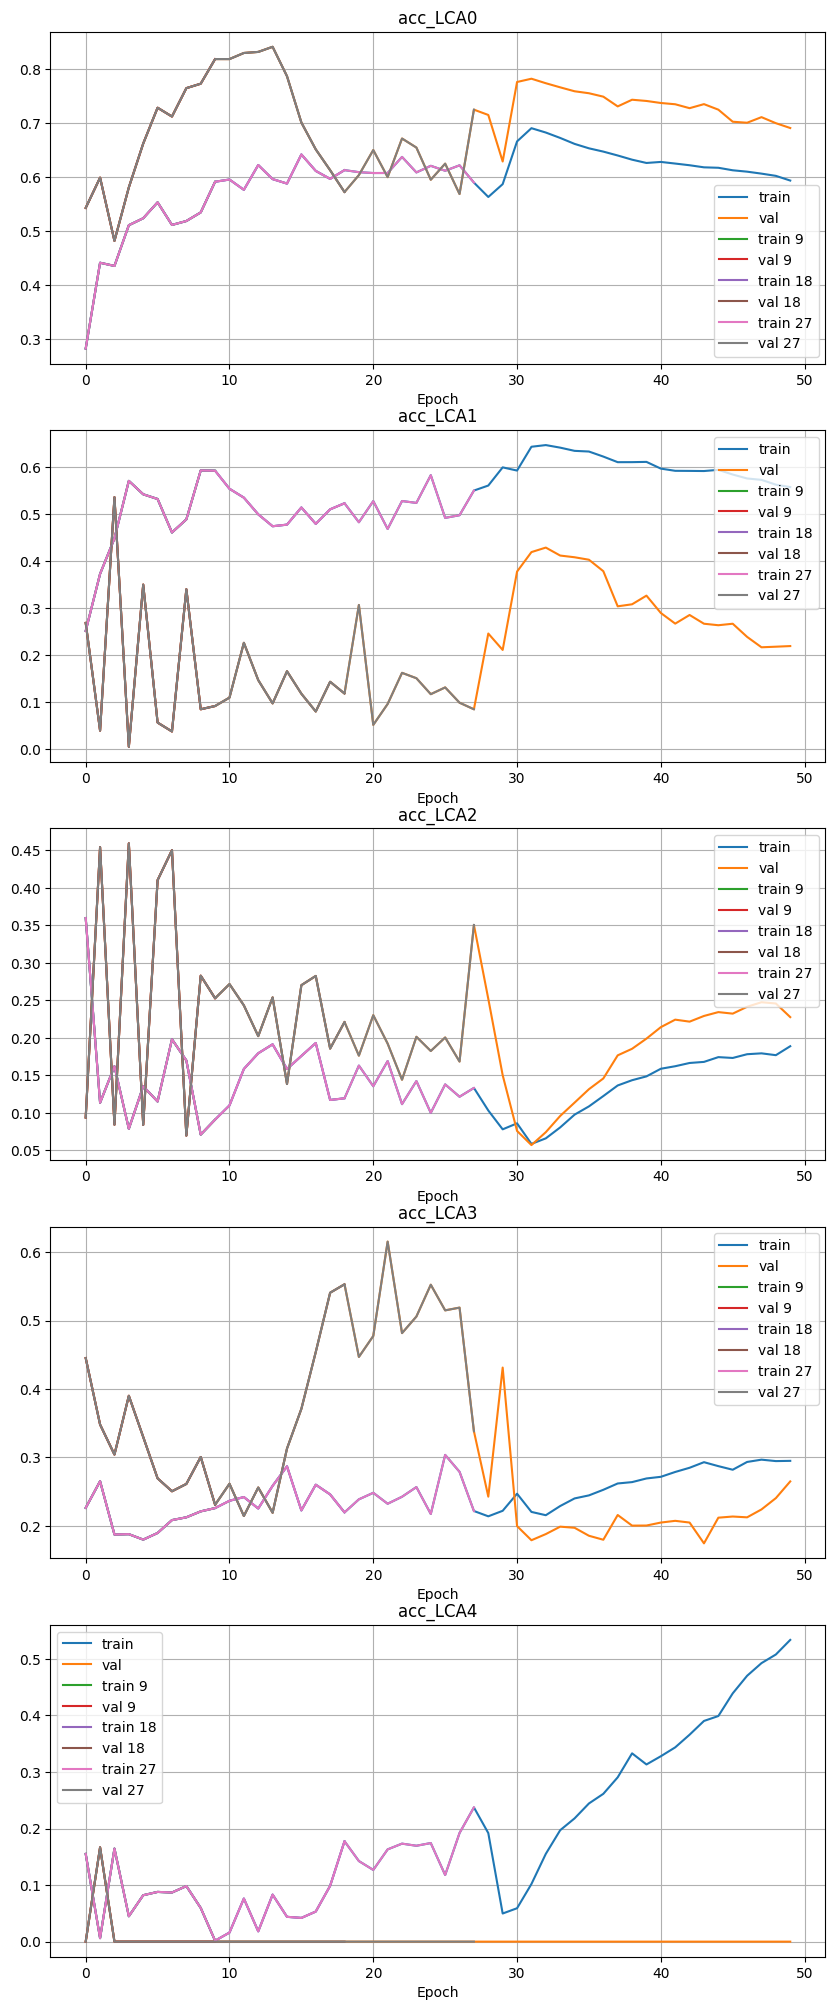

In [27]:
features = ['acc_LCA0', 'acc_LCA1', 'acc_LCA2', 'acc_LCA3', 'acc_LCA4']

Nfeatures = len(features)
fig, axs = plt.subplots(Nfeatures, 1, figsize=(10, 5*Nfeatures))
for i, feature in enumerate(features):
    
    axs[i].plot(dataset[f"train_{feature}"], label=f"train")
    axs[i].plot(dataset[f"val_{feature}"], label=f"val")
    
    # add checkpoints
    for epoch,history in histories.items():
        length = history['train']['acc'].shape[0]
        x = np.arange(0, epoch+1)
        axs[i].plot(x,history['train']['acc'][:,i], label=f"train {epoch}")
        axs[i].plot(x,history['val']['acc'][:,i], label=f"val {epoch}")
    
    axs[i].set_xlabel('Epoch')
    axs[i].grid()
    axs[i].set_title(feature)
    axs[i].legend()